## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pathlib import Path
START_DIR = Path('/content/drive/MyDrive/Colab_Notebooks/Fine_tuning_HF_SD_model_using_DreamBooth_LoRA')
# START_DIR = '.'
os.chdir(START_DIR)


In [ ]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
START_DIR

PosixPath('/content/drive/MyDrive/Colab_Notebooks/Fine_tuning_HF_SD_model_using_DreamBooth_LoRA')

## Download Stable Diffusion model from HuggingFace

In [ ]:
from diffusers import DiffusionPipeline
import json
from pathlib import Path


In [ ]:
# Define paths
MODELS_DIR = START_DIR / "HF_models"
parameters_file = START_DIR / "images_parameters.json"


In [ ]:
with open(parameters_file) as json_file:
    sdiff_dict = json.load(json_file)
models = sdiff_dict["sdiff_models"]

# Choose HuggingFace model
print("\n*** CHOOSE MODEL TO DOWNLOAD ***\n")
for model_id in models.keys():
    print(f"MODEL ID: {model_id}\n {models[model_id]}\n")

model_input = None
while model_input not in models.keys():
    model_input = input("Please input model_id: ")

hf_model = models[model_input]["name"]
model_name = hf_model.split("/")[-1]
MODEL_PATH = MODELS_DIR / model_name


*** CHOOSE MODEL TO DOWNLOAD ***

MODEL ID: regular
 {'name': 'stabilityai/stable-diffusion-2-1-base', 'resolution': 512, 'description': 'Basic SDiff model, does not work for groups of people'}

MODEL ID: high_res
 {'name': 'stabilityai/stable-diffusion-2-1', 'resolution': 768, 'description': 'The same training dataset as Basic SDiff model, but 768x768 px'}

MODEL ID: photorealistic
 {'name': 'dreamlike-art/dreamlike-photoreal-2.0', 'resolution': 768, 'description': 'Optimised for photos depicting people'}

MODEL ID: Mac
 {'name': 'apple/coreml-stable-diffusion-2-1-base', 'resolution': 512, 'description': 'Basic SDiff model converted into Core ML format'}

Please input model_id: photorealistic


In [ ]:
print(model_name, MODEL_PATH)

dreamlike-photoreal-2.0 /content/drive/MyDrive/Colab_Notebooks/Fine_tuning_HF_SD_model_using_DreamBooth_LoRA/HF_models/dreamlike-photoreal-2.0


In [ ]:
hf_model


'dreamlike-art/dreamlike-photoreal-2.0'

In [ ]:
# Downloading model from HuggingFace to cache
pipeline = DiffusionPipeline.from_pretrained(hf_model)


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
# Saving model from cache to local storage
pipeline.save_pretrained(MODEL_PATH)

## Inference

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://guq5oqgzq7s-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [ ]:
!python3 images_synthesise_individual.py

 * Serving Flask app 'images_synthesise_individual'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
^C


In [ ]:
from images_functions import ask_chatgpt, generate_images
from flask import Flask, render_template, request, Response
from flask_cors import CORS
import json
from pathlib import Path
from random import choice
from waitress import serve

In [ ]:
### Define the constants for Stable Diffusion
parameters_file = START_DIR / "images_parameters.json"
num_images_per_prompt = 2
num_inference_steps = 50

In [ ]:
### PROCESSED_INPUT is a product of user input pre-processing made on Frontend
processed_input = "Portrait of a white physician"
frontend_object_style = "Photo"


In [ ]:
# Retrieve available image parameters from JSON file
with open(parameters_file) as json_file:
    images_dict = json.load(json_file)

# Automatic prompt generation
task_1 = "Photo" if frontend_object_style == "Photo" else "Image"
chatgpt_response_prompt = ask_chatgpt(processed_input, task_1, images_dict["chatgpt_prompts"])

# Selecting SDiff model and object_style

if frontend_object_style == "Artistic":
    sdiff_model_type = "regular"
    object_style = choice(["Oil", "Line", "Anime", "Watercolors"])
else:
    detected_object = ask_chatgpt(chatgpt_response_prompt, "Detect", images_dict["chatgpt_prompts"])
    print(f"Detected object: {detected_object}")
    if "PEOPLE" in detected_object:
        sdiff_model_type = "photorealistic"
        object_style = "Photography"
    elif "PERSON" in detected_object:
        sdiff_model_type = "photorealistic"
        object_style = "Portrait"
    else:
        sdiff_model_type = "regular"
        object_style = "Photography"

print(f"SDiff model type: {sdiff_model_type}, Object style: {object_style}")



*** COMMERCIAL USE IS FORBIDDEN ***


*** COMMERCIAL USE IS FORBIDDEN ***

Detected object: PEOPLE
SDiff model type: photorealistic, Object style: Photography


In [ ]:
# Construct final prompt for image generation
style_prefix = images_dict["object_style"][object_style]["prompt_prefix"]
style_suffix = images_dict["object_style"][object_style]["prompt_suffix"]
negative_prompt = images_dict["object_style"][object_style]["negative_prompt"]
sdiff_model = images_dict["sdiff_models"][sdiff_model_type]["name"].split("/")[-1]

image_prompt = f"{style_prefix} {chatgpt_response_prompt}, {style_suffix}."

# Define the paths and parameters
MODEL_PATH = START_DIR / "HF_models" / sdiff_model

# Print image generation data for debugging
print("SDiff model", MODEL_PATH)
print("Prompt: ", image_prompt)

SDiff model /content/drive/MyDrive/Colab_Notebooks/Fine_tuning_HF_SD_model_using_DreamBooth_LoRA/HF_models/dreamlike-photoreal-2.0
Prompt:  Photo of A white physician, professional, caring, knowledgeable, experienced, captured by a digital camera, using a portrait lens, during daytime, with natural lighting, in a formal style, without any filter., excellent composition, main object in the middle, very inspirational, aesthetic, award winning photo, highly detailed, in a charming style.


In [ ]:
image_response = generate_images(
            image_prompt=image_prompt,
            MODEL_PATH=MODEL_PATH,
            custom_model_path="",
            USER_DIR="",
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            save_images=True,
        )

Successfully loaded base model /content/drive/MyDrive/Colab_Notebooks/Fine_tuning_HF_SD_model_using_DreamBooth_LoRA/HF_models/dreamlike-photoreal-2.0

*** COMMERCIAL USE IS FORBIDDEN ***



  0%|          | 0/50 [00:00<?, ?it/s]

Images saved on local drive in [./output/dreamlike-photoreal-2.0/photo-of-a-white-physician-professional-caring-knowledgeable-experienced-captured-by-a-digital-camera-using-a-portrait-lens-during-daytime-with-natural-lighting-in-a-formal-style-without-any-filter-excellent-composition-main-object-in-the-middle-very-inspirational-aesthetic-award-winning-photo-highly-detailed-in-a-charming-style] folder


In [ ]:
!ls ./output/dreamlike-photoreal-2.0/

photo-of-a-doctor-professional-caring-determined-busy-captured-with-a-digital-camera-using-a-zoom-lens-during-daylight-hours-brightly-lit-in-a-candid-style-with-a-modern-sensor-excellent-composition-main-object-in-the-middle


In [ ]:
# HTTP responce to Front-end
Response(json.dumps(image_response), mimetype='application/json')

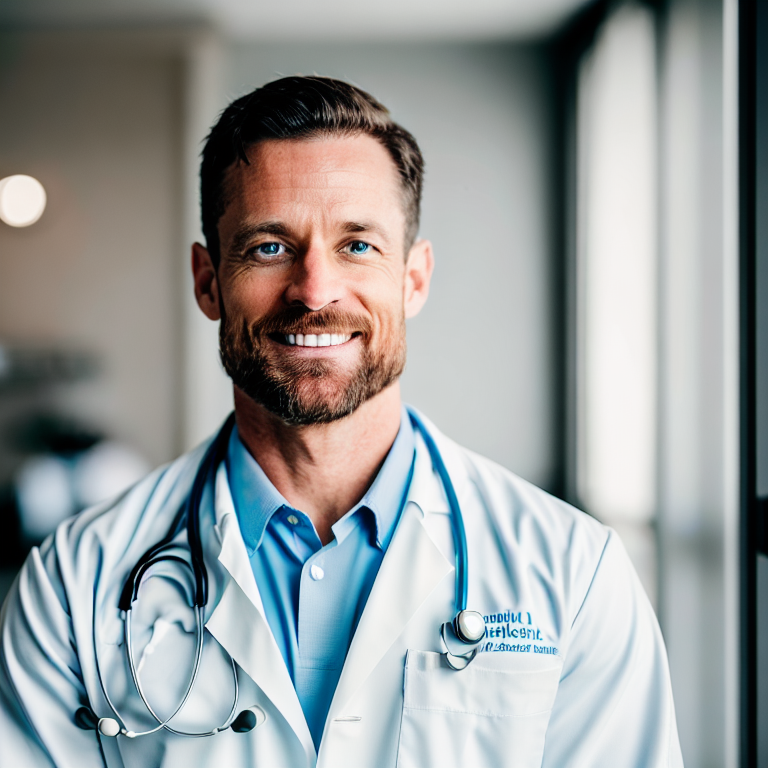

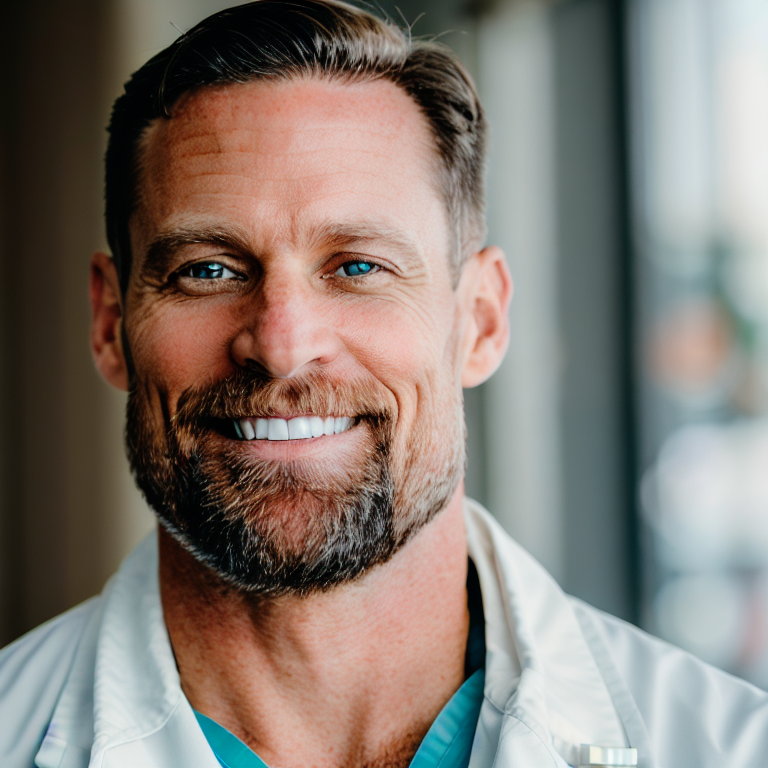

In [ ]:
# Manually displays all generated images
import base64
import io
from PIL import Image
from IPython.display import display


for idx, im in enumerate(image_response):
  img = Image.open(io.BytesIO(base64.b64decode(im)))
  display(img)

In [ ]:
# Run app in debugging (vanilla Flask on default "127.0.0.1:5000")

app.run(debug=True)

In [ ]:
# Run app in production (Waitress)
serve(app, host=localhost, port=8080)